In [3]:
cd /mnt/sda/otani/Experiments/moment_retrieval

/mnt/sda/otani/Experiments/moment_retrieval


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.toolbox.eval import evaluate, accumulate_metrics, categorize_results, summarize_results_per_class
from src.toolbox.utils import _nms
from src.toolbox.visualization import plot_performance_per_class, plot_performance_per_duration
from src.toolbox.data_converters import CharadesSTA2Instances
import seaborn as sns
import pickle as pkl
import json
import neptune
sns.set_style("white")

In [5]:
# load ground truth test set
test_data = CharadesSTA2Instances(pd.read_csv('data/processed/test.csv'))

In [9]:
project = neptune.init("mayu-ot/moment-retrieval")
exp_id = "MOM-6"
if not os.path.exists(f"tmp/{exp_id}/{exp_id}199.json"):
    exps = project.get_experiments(id=exp_id)
    print("downloading results ...")
    exps[0].download_artifact(f"{exp_id}199.json", f"tmp/{exp_id}")
    print("done!")
    
exp_id = "MOM-7"
if not os.path.exists(f"tmp/{exp_id}/{exp_id}199.shuffle.json"):
    exps = project.get_experiments(id=exp_id)
    print("downloading results ...")
    exps[0].download_artifact(f"{exp_id}199.shuffle.json", f"tmp/{exp_id}")
    print("done!")

downloading results ...
done!


In [10]:
def get_duration(video_id):
    for x in test_data:
        if x[0][0] == video_id:
            return x[1][-1]

def get_evaluation_results(predictions):
    preds = []
    for p in predictions:
        query = (p[0], p[2]+".")
        video_duration = get_duration(query[0])
        seg = [s + [video_duration] for s in p[3][:10]]
        preds.append((query, seg, p[5][:10]))
    results = evaluate(test_data, preds)
    summary = accumulate_metrics(results)
    return results, summary

In [13]:
predictions = json.load(open(f"tmp/MOM-6/MOM-6199.json"))
results, summary = get_evaluation_results(predictions)

8 missing instances
missing item: ('U2AO1', 'closes the doors.the person takes the food.')
missing item: ('SVIXG', 'person opening a box.')
missing item: ('SVIXG', 'person eating from a box of food.')
missing item: ('SVIXG', 'person eating something out of it.')
missing item: ('SVIXG', 'person eats a few pieces from inside.')
missing item: ('7JHW2', 'the person puts the laptop down onto a table.')
missing item: ('7JHW2', 'a person runs into the garage.')
missing item: ('7JHW2', 'person holding a laptop.')
missing item: ('7JHW2', 'person sets a laptop computer on a counter.')
R@1 IoU>0.3 0.65
R@1 IoU>0.5 0.52
R@1 IoU>0.7 0.31
R@5 IoU>0.3 0.82
R@5 IoU>0.5 0.73
R@5 IoU>0.7 0.56
R@10 IoU>0.3 0.82
R@10 IoU>0.5 0.73
R@10 IoU>0.7 0.56


In [14]:
predictions = json.load(open(f"tmp/MOM-7/MOM-7199.shuffle.json"))
randomized_results, randomized_summary = get_evaluation_results(predictions)

8 missing instances
missing item: ('U2AO1', 'closes the doors.the person takes the food.')
missing item: ('SVIXG', 'person opening a box.')
missing item: ('SVIXG', 'person eating from a box of food.')
missing item: ('SVIXG', 'person eating something out of it.')
missing item: ('SVIXG', 'person eats a few pieces from inside.')
missing item: ('7JHW2', 'the person puts the laptop down onto a table.')
missing item: ('7JHW2', 'a person runs into the garage.')
missing item: ('7JHW2', 'person holding a laptop.')
missing item: ('7JHW2', 'person sets a laptop computer on a counter.')
R@1 IoU>0.3 0.39
R@1 IoU>0.5 0.25
R@1 IoU>0.7 0.12
R@5 IoU>0.3 0.65
R@5 IoU>0.5 0.49
R@5 IoU>0.7 0.31
R@10 IoU>0.3 0.65
R@10 IoU>0.5 0.49
R@10 IoU>0.7 0.31


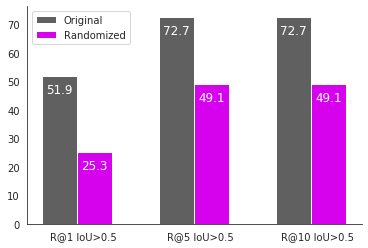

In [15]:
# The performances of the 2D-TAN model when the original and randomized videos are fed to the model
def display_score(bar, color="w"):
    plt.text(
        bar.get_x()+bar.get_width()*.5,
        bar.get_height()-6,
        f"{bar.get_height():.1f}",
        horizontalalignment="center",
        fontsize=12,
        color=color
    )
    
plt.figure(figsize=(6, 4))
c = ["#606060", "#d602ee"]
labels = ["Original", "Randomized"]
keys = [f"R@{k} IoU>0.5" for k in [1, 5, 10]]
x = np.arange(3)+0.2
for score_summary in [summary, randomized_summary]:
    vals = [score_summary[k] * 100 for k in keys]
    bars = plt.bar(x, vals, width=0.3, color=c.pop(0), label=labels.pop(0))
    for b in bars:
        display_score(b, color="w")
    x += 0.3
    
plt.xticks(ticks=np.arange(3)+0.4, labels=keys, ha="center")
    
plt.legend()
sns.despine(left=False)

Text(0.5, 1.0, 'Randomized video input')

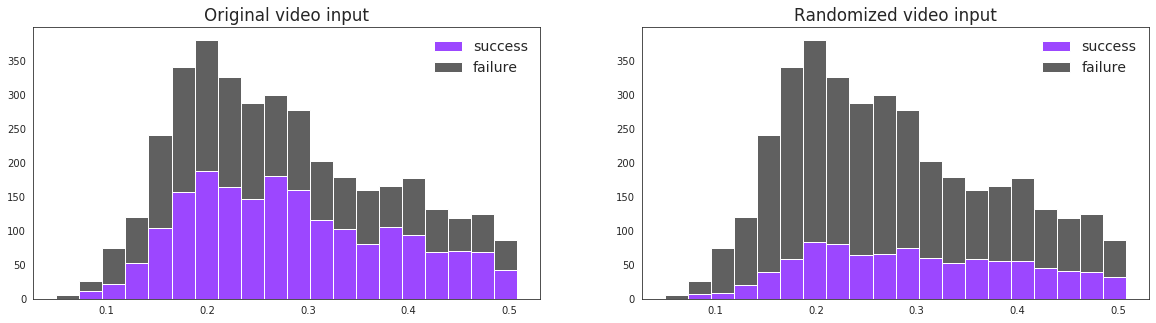

In [16]:
# Check relation between success rates and iput video durations
f, axes = plt.subplots(1, 2, figsize=(20, 5))
plt.rcParams.update({'font.size': 14})
_ = plot_performance_per_duration(results, test_data, ax=axes[0])
axes[0].set_title("Original video input")
_ = plot_performance_per_duration(randomized_results, test_data, ax=axes[1])
axes[1].set_title("Randomized video input")